# Calories burn prediction

Thank you for providing that additional context. It's clear that you're aiming to create an application that predicts calorie burn based on user inputs. Let's refine the problem statement further to incorporate this specific goal:

# 1) Problem Statement

In today's health-conscious society, individuals are increasingly seeking personalized tools to support their fitness goals. This project aims to develop a data-driven application that predicts calorie burn during physical activities based on individual characteristics and exercise parameters.

### Objective:
To create a user-friendly application that accurately estimates calorie expenditure for a given exercise duration, taking into account various personal factors.

Key Features:
1. Input parameters: The application will accept user inputs including age, gender, height, weight, and exercise duration.
2. Calorie burn prediction: Using these inputs, the app will calculate an estimate of calories burned during the specified activity period.
3. Comparative analysis: Users will be able to view similar results and general information based on their input parameters, providing context for their personal results.

Dataset:
The application will be built upon a dataset containing the following variables:
- User demographics: User ID, Gender, Age, Height, Weight
- Activity metrics: Duration of exercise
- Physiological responses: Heart Rate, Body Temperature

Expected Outcomes:
1. A reliable calorie burn prediction model
2. An intuitive application interface for users to input their data and receive personalized calorie burn estimates
3. Insights into the relationships between personal characteristics, exercise duration, and calorie expenditure

By developing this application, we aim to provide users with a valuable tool for understanding and optimizing their exercise routines, contributing to more effective personal fitness management in our health-conscious society.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

# Setting random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Initial Exploration
### Read Data

In [2]:
df_feature = pd.read_csv("D:\\ProjectsEuron\\CaloriesBurnPrediction\\data\\exercise.csv")

In [3]:
df_feature.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


In [4]:
df_lebel = pd.read_csv("D:\\ProjectsEuron\\CaloriesBurnPrediction\\data\\calories.csv")

In [5]:
df_lebel.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [6]:
df = pd.merge(df_feature, df_lebel, on="User_ID")

In [7]:
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [8]:
df.to_csv('D:\\ProjectsEuron\\CaloriesBurnPrediction\\CaloriesBurn.csv', index=False)

#### Checking basic details

In [9]:
# shape (rows and columns)
print(f'There are {df.shape[0]} number of rows(observations) and {df.shape[1]} number of columns')

There are 15000 number of rows(observations) and 9 number of columns


In [10]:
# basic description of data
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [11]:
# culumns 
df.columns

Index(['User_ID', 'Gender', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Calories'],
      dtype='object')

In [12]:
df.dtypes

User_ID         int64
Gender         object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

##### Observation :
- There are 6 columns of fload64 type, 2 are of int64 type and 1 is of object type.

In [13]:
# checking the basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


##### Observation :
- All columns have constraint 'non-null'
- Memory usage 1 MB

In [14]:
df.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

##### Observation :
- No columns contain null value
- Memory usage 1 MB

In [15]:
# checking the duplicated values
df.duplicated().sum()

0

##### Observation :
- There is no duplicate values

In [16]:
!pip install skimpy

In [17]:
from skimpy import skim

In [18]:
# Summerizing the dataset

skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 15000  │ │ float64     │ 6     │                                                          │
│ │ Number of columns │ 9      │ │ int32       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_na ┃    ┃      ┃          ┃         ┃          ┃          ┃          ┃          ┃          ┃        ┃  │
│ ┃ me        ┃ NA ┃ NA % ┃ mean     ┃ sd      ┃ p0       ┃ p25      ┃ p50      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ User_ID   │  0 │    0 │ 14980000 │ 2873000 │ 10000000 │ 12470000 │ 15000000 │ 17450000 │ 20000000 │ ▇▇▇▇▇▇ │  │
│ │ Age       │  0 │    0 │    42.79 │   16.98 │       20 │       28 │       39 │       56 │       79 │ ▇▆▅▃▃▃ │  │
│ │ Height    │  0 │    0 │    174.5 │   14.26 │      123 │      164 │      175 │      185 │      222 │  ▂▇▇▃  │  │
│ │ Weight    │  0 │    0 │    74.97 │   15.04 │       36 │       63 │       74 │       87 │      132 │ ▁▇▇▆▁  │  │
│ │ Duration  │  0 │    0 │    15.53 │   8.319 │        1 │        8 │       16 │       23 │       30 │ ▇▇▇▇▇▇ │  │
│ │ Heart_Rat │  0 │    0 │    95.52 │   9.583 │       67 │       88 │       96 │      103 │      128 │ ▁▅▇▇▃  │  │
│ │ e         │    │      │          │         │          │          │          │          │          │        │  │
│ │ Body_Temp │  0 │    0 │    40.03 │  0.7792 │     37.1 │     39.6 │     40.2 │     40.6 │     41.5 │  ▁▂▅▇▃ │  │
│ │ Calories  │  0 │    0 │    89.54 │   62.46 │        1 │       35 │       79 │      138 │      314 │ ▇▆▅▃▁  │  │
│ └───────────┴────┴──────┴──────────┴─────────┴──────────┴──────────┴──────────┴──────────┴──────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Gender                    │       0 │          0 │                            1 │                    15000 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

##### Observation :
- Age, Calories got right-skewed distribution.
- Body temperature got left-skewed distribution.

## 2. Data Visualization

C:\Users\Ineuron\AppData\Local\Temp\ipykernel_24984\1284610988.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, palette="tab10")


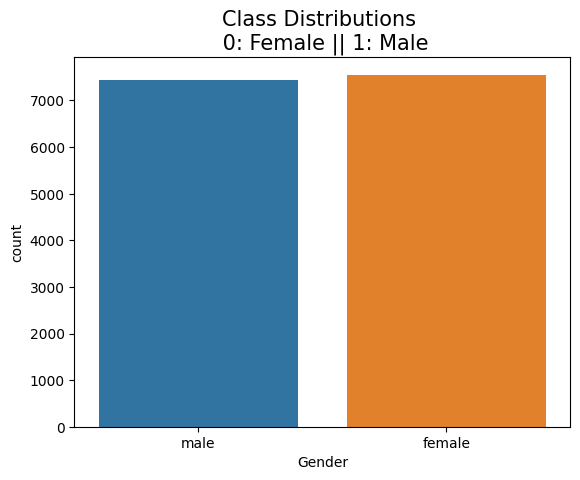

In [19]:
sns.countplot(x='Gender', data=df, palette="tab10")
plt.title('Class Distributions \n 0: Female || 1: Male', fontsize=15)
plt.show()

##### Observation :
- There are more female then male

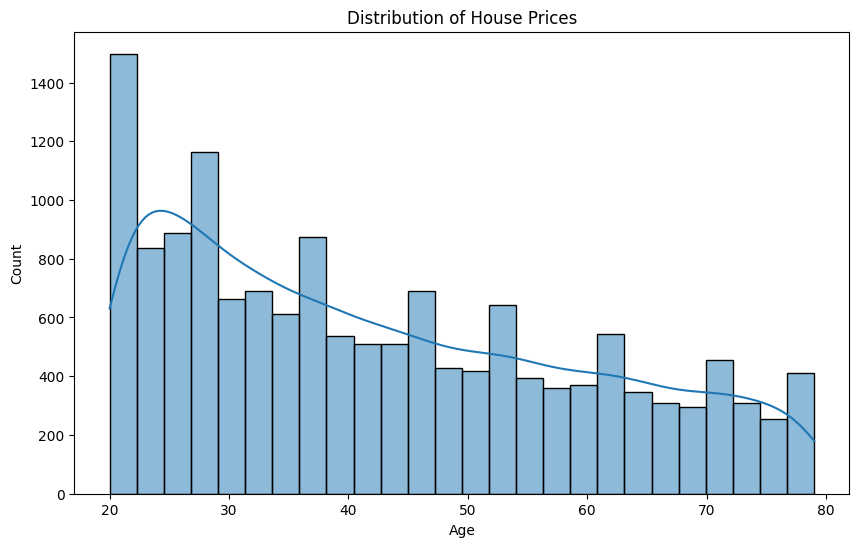

In [20]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True)
plt.title('Distribution of House Prices')
plt.show()

##### Observation :
- Age column is is slight right skewed.

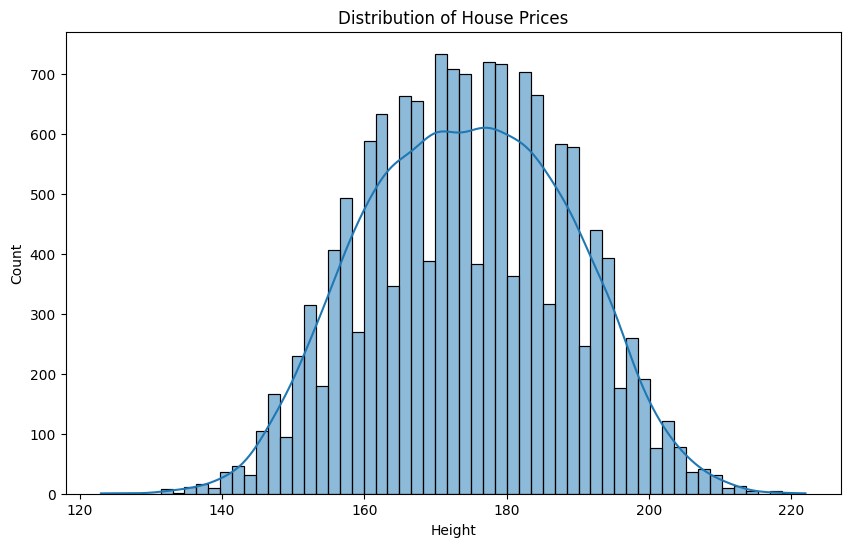

In [21]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Height'], kde=True)
plt.title('Distribution of House Prices')
plt.show()

##### Observation :
- Height column got a normal distribution.

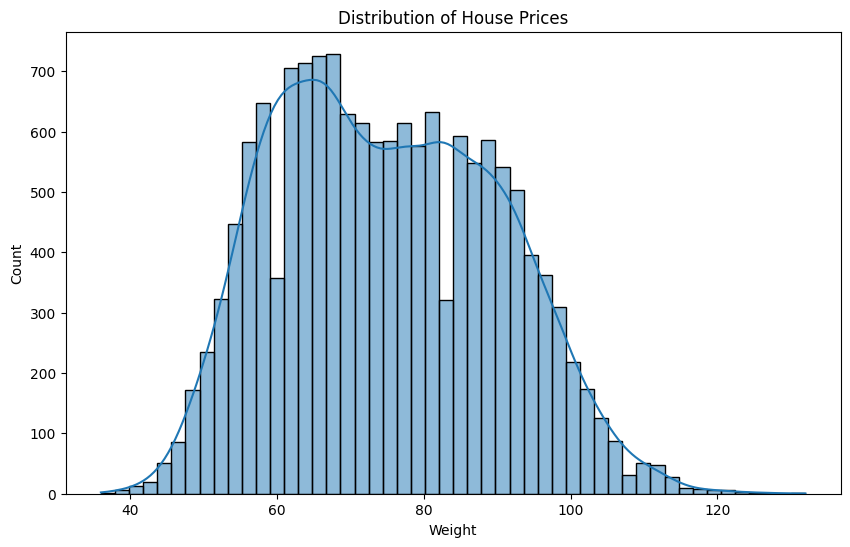

In [22]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Weight'], kde=True)
plt.title('Distribution of House Prices')
plt.show()

##### Observation :
- Weight column is nearly normally distributed.

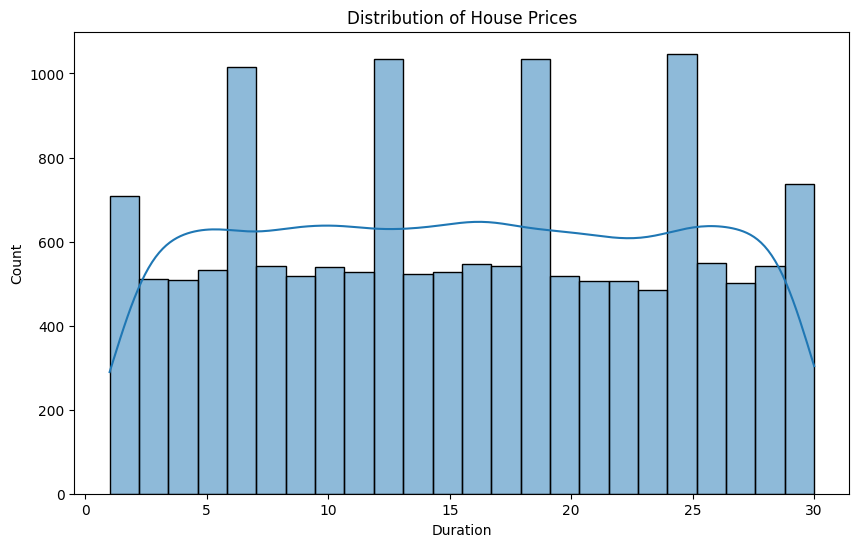

In [23]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Duration'], kde=True)
plt.title('Distribution of House Prices')
plt.show()

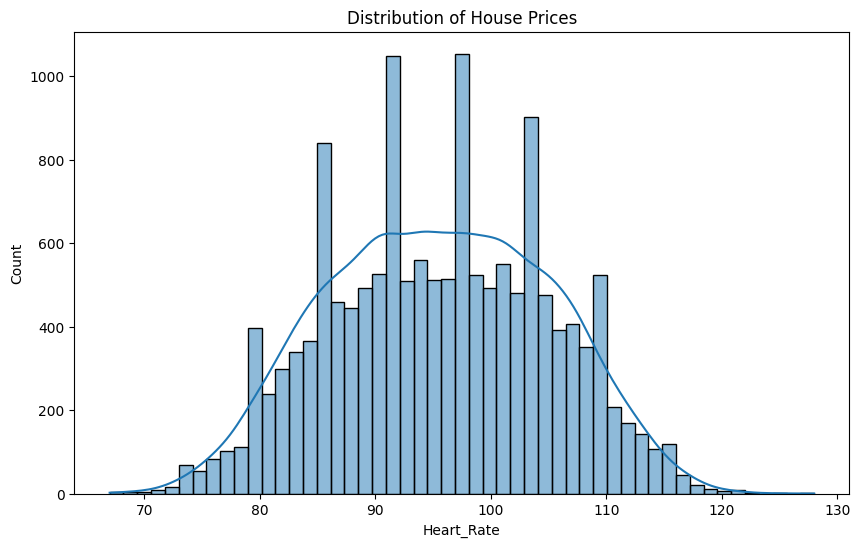

In [24]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Heart_Rate'], kde=True)
plt.title('Distribution of House Prices')
plt.show()

##### Observation :
- Heart Rate column got a normal distribution.

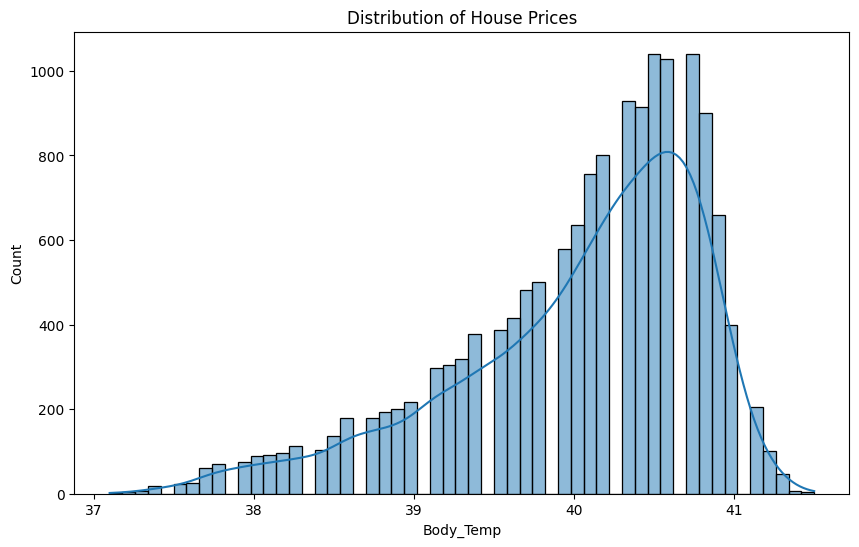

In [25]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Body_Temp'], kde=True)
plt.title('Distribution of House Prices')
plt.show()

##### Observation :
- Body temp column is left skewed distributed.

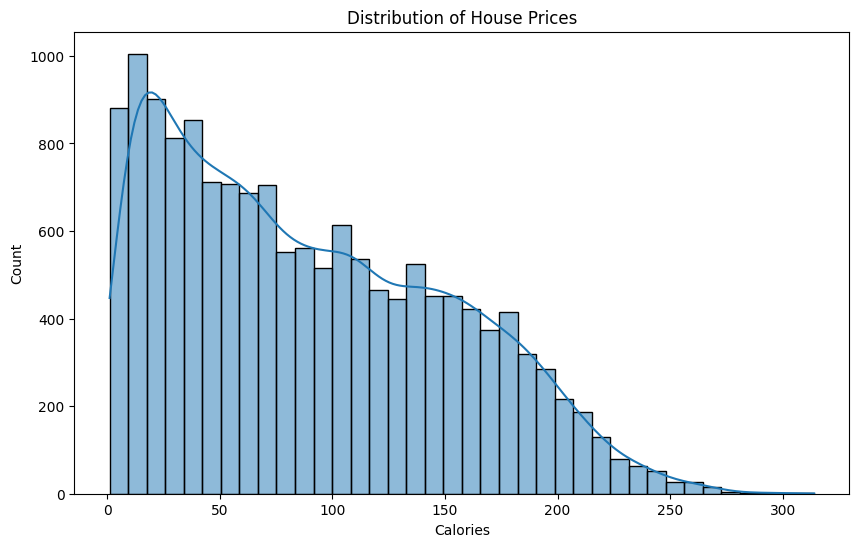

In [26]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Calories'], kde=True)
plt.title('Distribution of House Prices')
plt.show()

##### Observation :
- Calories column is right skewed distributed.

### Transforming object type column to numeric

In [27]:
df['Gender'] = df['Gender'].map({'male':1, 'female':0})

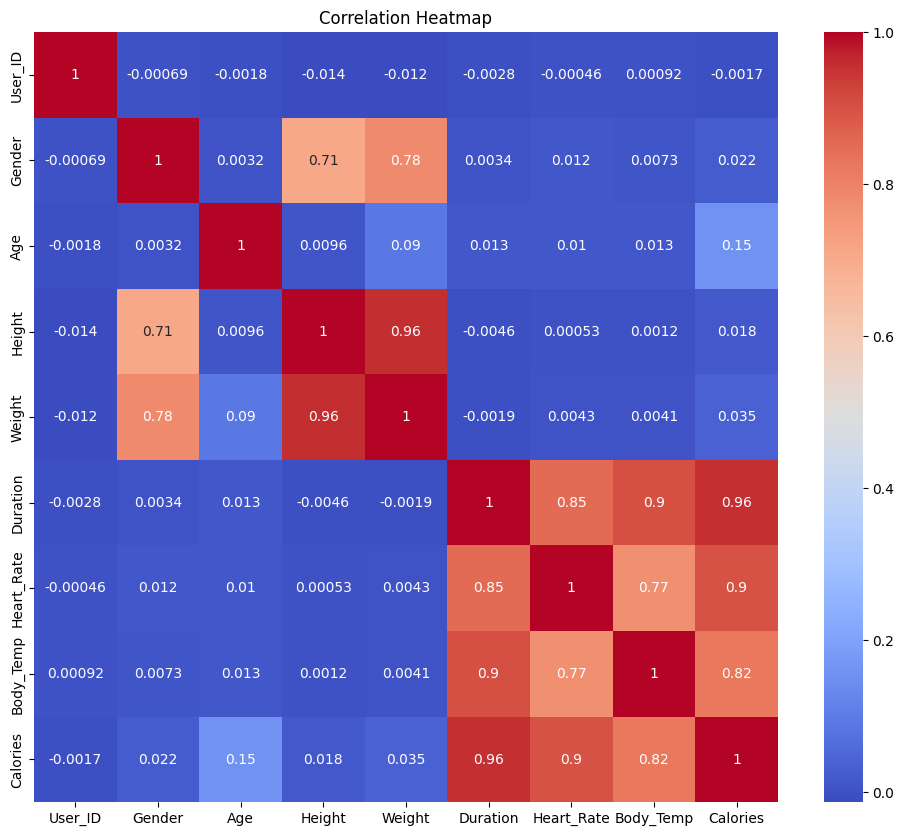

In [28]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Dropping column "User_ID" as it is not required for prediction

In [29]:
df.drop(['User_ID'], axis=1, inplace=True)

## 3. Data Preprocessing

In [30]:
# Separate features and target
X = df.drop('Calories', axis=1)
y = df['Calories']

In [31]:
X.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp'],
      dtype='object')

In [32]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Observation :
- Features are scaled to ensure all variables contribute equally to the model.

## 4. Model Training and Evaluation

In [34]:
def evaluate_models(X_train, X_test, y_train, y_test, models):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append({
            'Model': name,
            'MSE': mse,
            'R2 Score': r2
        })
    return pd.DataFrame(results)

In [35]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

results = evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test, models)
print(results)

               Model         MSE  R2 Score
0  Linear Regression  131.995746  0.967294
1   Ridge Regression  132.001941  0.967292
2   Lasso Regression  157.801971  0.960899
3      Random Forest    7.091619  0.998243
4            XGBoost    4.568956  0.998868


##### Observation :
- We are getting the maximum accuracy in XGBoost Regressor. So we will be going with that model.

In [36]:
# Assuming XGBoost performed best
best_model = XGBRegressor()

#### Hyper-parameter tuning

In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3]
}

In [38]:
grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

In [39]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [40]:
print("Best parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best MSE: 2.882475882912222


#### Observation:

- We got the best parameters to balance model complexity and performance using XGBoostRegressor

## 6. Final Model Evaluation

In [41]:
# Model training
final_model = grid_search.best_estimator_
final_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
# Prediction
y_pred = final_model.predict(X_test_scaled)

In [43]:
# Claculating error
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [44]:
print(f"Final Model MSE: {mse}")
print(f"Final Model R2 Score: {r2}")


Final Model MSE: 2.186644913805089
Final Model R2 Score: 0.999458186844864


In [45]:
# Feature Importance
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)
print(importances)

      feature  importance
4    Duration    0.894552
5  Heart_Rate    0.055670
1         Age    0.025532
0      Gender    0.018618
3      Weight    0.005246
6   Body_Temp    0.000196
2      Height    0.000187


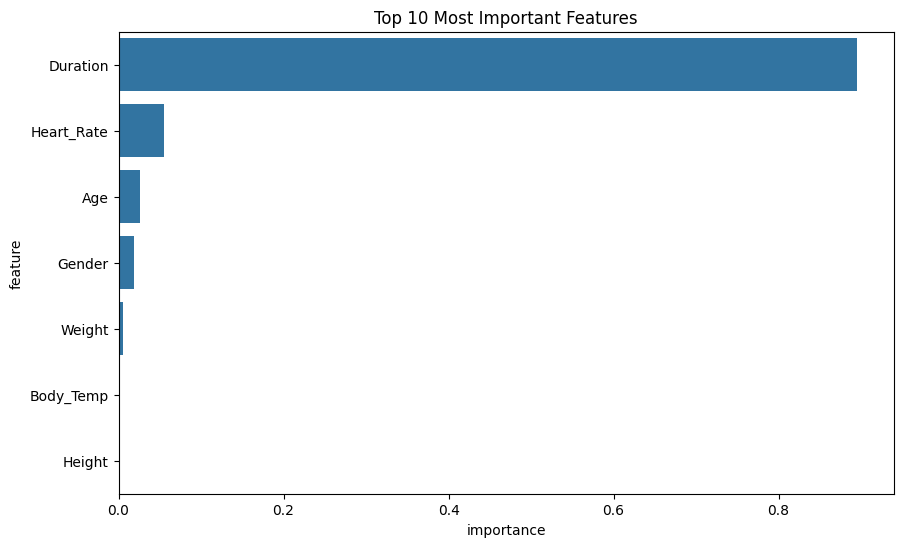

In [46]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances.head(10))
plt.title('Top 10 Most Important Features')
plt.show()

#### Observation:

- We can observe, duration is having the most importance in burning calorie while doing physical activities.

## 7. Residual Analysis

In [47]:
residuals = y_test - y_pred

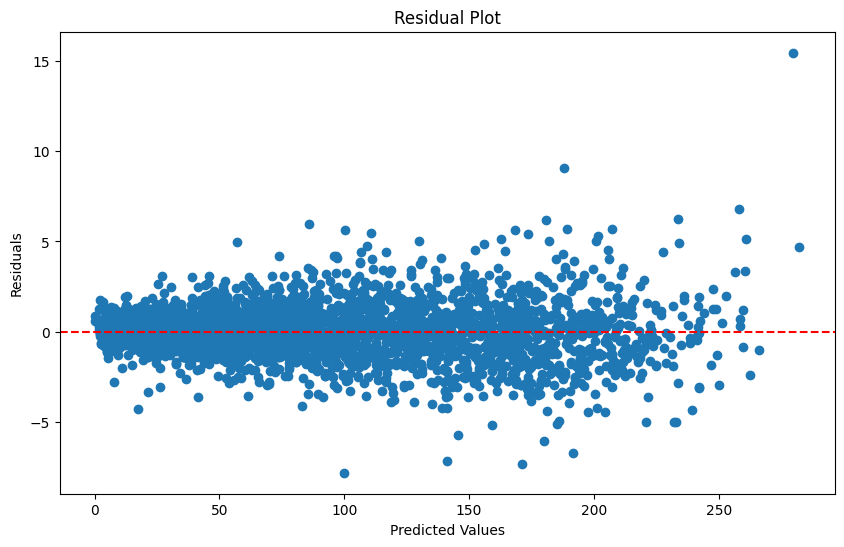

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

<Figure size 1000x600 with 0 Axes>

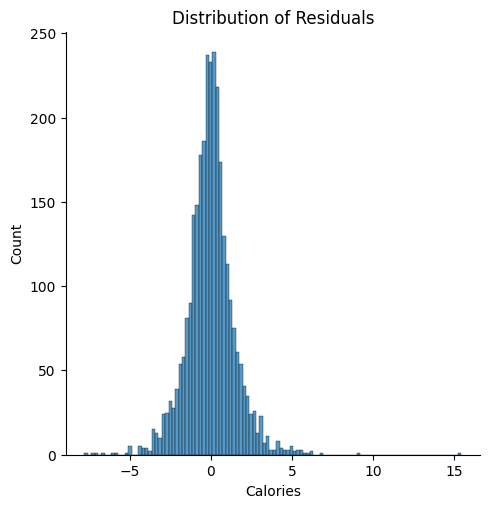

In [49]:
plt.figure(figsize=(10, 6))
sns.displot(residuals)
plt.title('Distribution of Residuals')
plt.show()

#### Observation:

- Most of the errors are zero centric. But there are some outliers.

## 8. Model Persistence

In [50]:
# Saving the model and scaler for easy deployment and future use without retraining.
import joblib # same as dill

# Save the model
joblib.dump(final_model, 'calories_burn.joblib')

['calories_burn.joblib']

In [51]:
# Save the scaler
joblib.dump(scaler, 'scaler.joblib')
print("Model and scaler saved successfully.")

Model and scaler saved successfully.
